## CREATE AND CUT THE GRAPH

In [118]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
# !pip install leidenalg==0.7.0

In [120]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import numpy
import skimage.color
import torch.nn.functional as F
from MODULES.graph_clustering import *
import time

## Import files

In [121]:
# LARGE
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL_v2.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_LARGE.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL_v3.pt" 

mask_file_hard = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_HARD_EDGES.pt"
mask_file_dot = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_DOT_PRODUCT.pt"
mask_file_l1norm = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_L1_NORM.pt"
mask_file_l2norm = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_L2_NORM.pt"

## Helper function

In [142]:
def all_together_hdbscan(g):
    partition = g.find_partition_hdbscan()
    g.plot_partition(partition, size_threshold=10, figsize=(12,12), density=False, bins=10)

In [143]:
def all_together_watershed(g):
    partition = g.find_partition_watershed()
    g.plot_partition(partition, size_threshold=10, figsize=(12,12), density=False, bins=10)

In [144]:
def all_together_leiden(g, resolution):
    partition = g.find_partition_leiden(resolution=resolution)
    g.plot_partition(partition, size_threshold=10, figsize=(12,12), density=False, bins=10) #, range=(10,300), windows=[1000,1100,2000,2100])

## Load and plot

In [160]:
tiling = torch.load(mask_file_dot, map_location=torch.device('cpu'))
tiling = tiling.reduce_similarity_radius(new_radius = 8)

g = GraphSegmentation(tiling, normalize_graph_edges=False)

debug connected components tensor([   0, 2037, 1096,  123])


In [161]:
g.graph.summary()

'IGRAPH U-W- 3256 274232 -- \n+ attr: d (v), label (v), size (v), weight (e)'

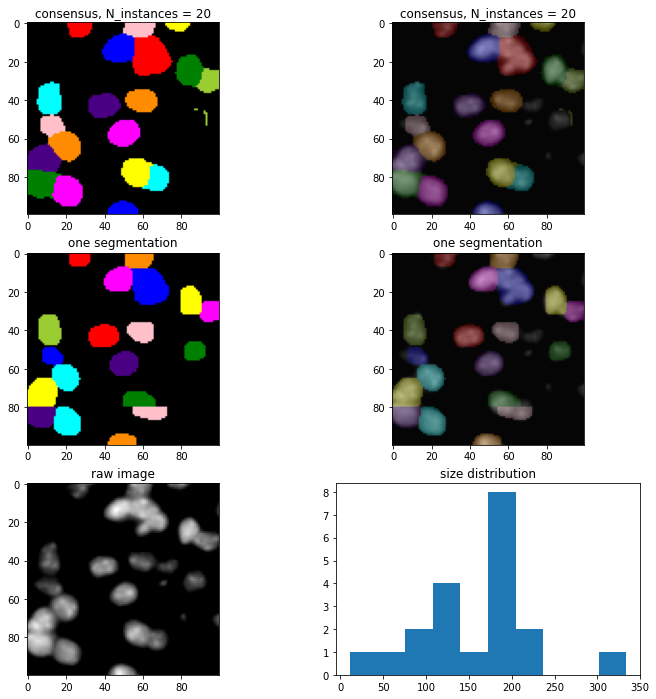

In [169]:
all_together_leiden(g, resolution=1.9)

In [136]:
g.graph.es["weight"]

[0.040928009897470474,
 0.7575568556785583,
 0.8683187961578369,
 0.8902979493141174,
 0.8912774324417114,
 0.8912776112556458,
 0.8912776708602905,
 0.891277551651001,
 0.7692912817001343,
 0.7692912817001343,
 0.7669718861579895,
 0.2632819712162018,
 0.4999835789203644,
 0.98581862449646,
 0.9858908653259277,
 0.9858909249305725,
 0.9858909249305725,
 0.9858909249305725,
 0.9858909249305725,
 0.9858909249305725,
 0.8648382425308228,
 0.9883217811584473,
 0.9883217215538025,
 0.9883217215538025,
 0.9883217215538025,
 0.883190393447876,
 0.06281924247741699,
 0.14967602491378784,
 0.6530646681785583,
 0.8127338290214539,
 0.8360443711280823,
 0.8360450863838196,
 0.83604496717453,
 0.83604496717453,
 0.7388710975646973,
 0.7388816475868225,
 0.7323542237281799,
 0.7077128291130066,
 0.13044434785842896,
 0.0366642102599144,
 0.7523810863494873,
 0.8884890675544739,
 0.8912773132324219,
 0.8912776112556458,
 0.8912776112556458,
 0.8912776708602905,
 0.8912776708602905,
 0.7692912817001

In [129]:
#ig.plot(g.graph)

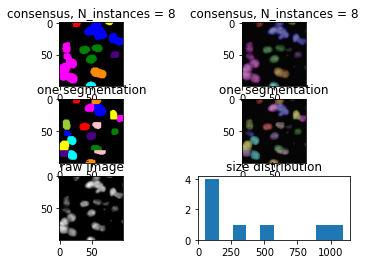

In [137]:
g.plot_cc()

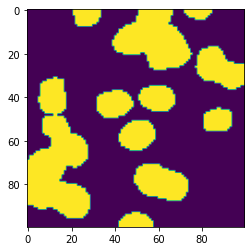

In [102]:
plt.imshow(g.img_to_flood)

13


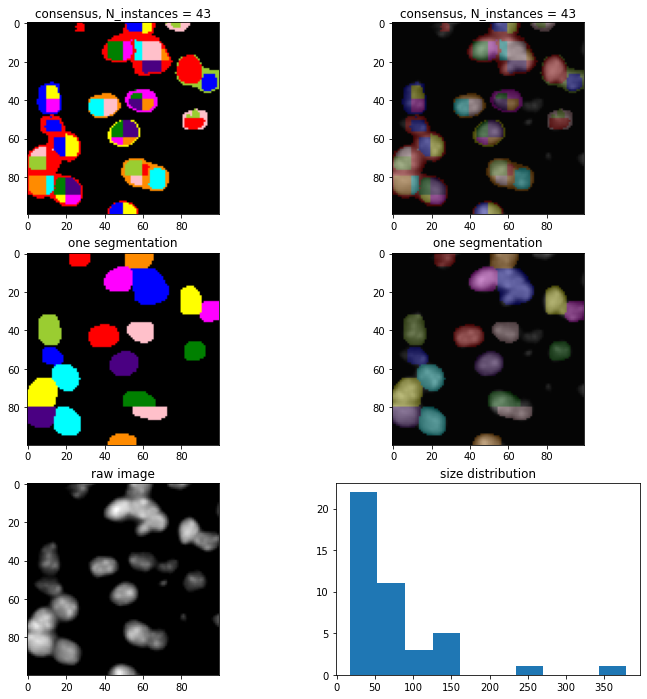

In [105]:
all_together_hdbscan(g)

[autoreload of MODULES.graph_clustering failed: Traceback (most recent call last):
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 

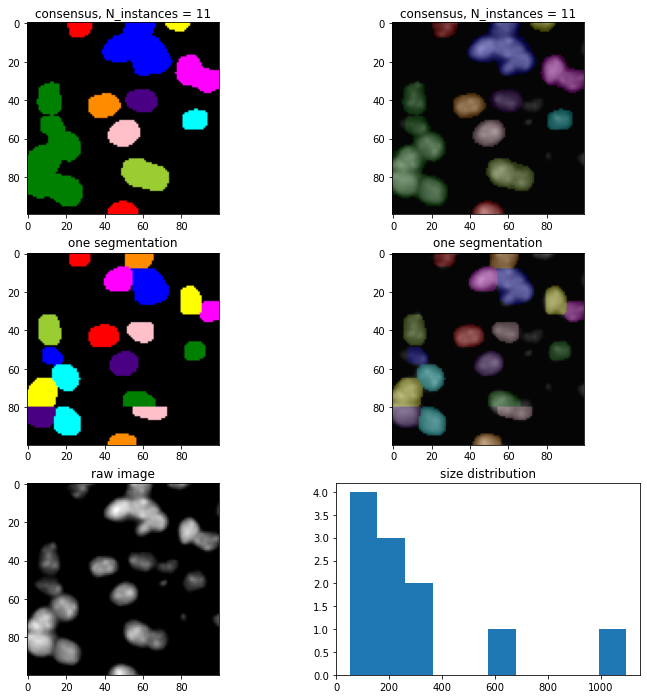

In [21]:
all_together_watershed(g)

1
0
cluster 0 out of 1


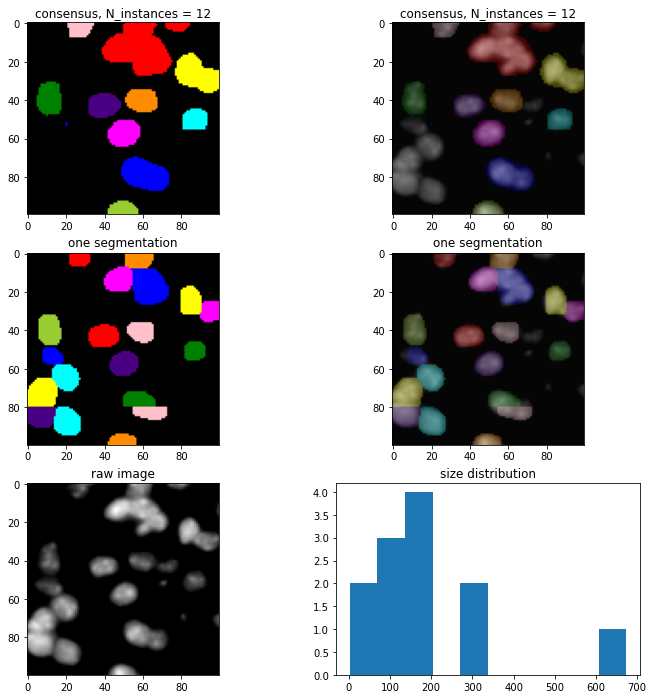

In [557]:
all_together_leiden(g, resolution=0.0001)

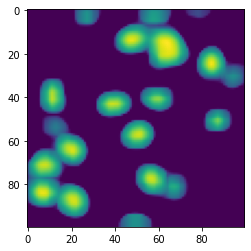

In [362]:
#plt.imshow(g.img_to_flood)

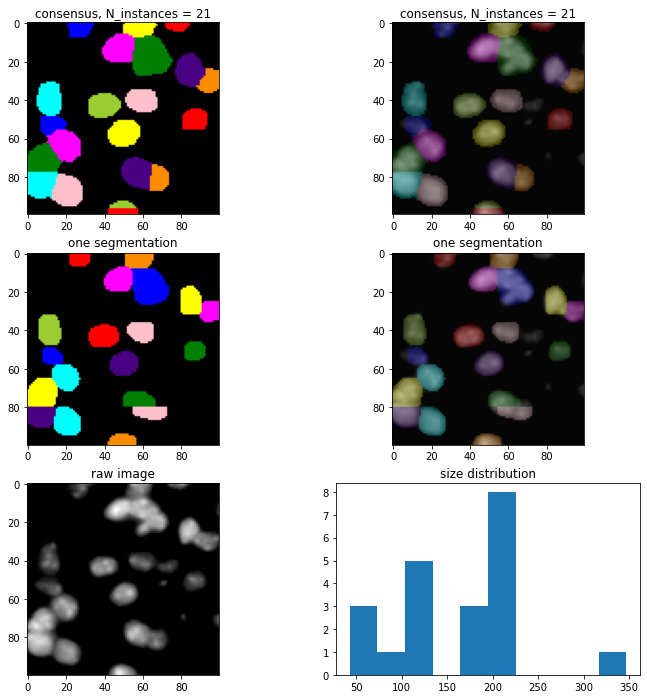

In [361]:
all_together_watershed(g)